# Homework 08 – Campaign Response Model

## Import Library

In [36]:
import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

import xgboost as xgb
from xgboost import plot_importance

## Import Dataset

In [2]:
retail_respond = pd.read_csv("/content/drive/MyDrive/BADS7105/Retail_Data_Response.csv")
retail_transac = pd.read_csv("/content/drive/MyDrive/BADS7105/Retail_Data_Transactions.csv")

In [3]:
retail_respond.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
retail_transac.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


## Preparing Dataset

In [5]:
retail_transac['trans_date'] = pd.to_datetime(retail_transac['trans_date'])

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
retail_transac['recent_day'] = campaign_date - retail_transac['trans_date']
retail_transac['recent_day'].astype('timedelta64[D]')
retail_transac['recent_day'] =retail_transac['recent_day'] / np.timedelta64(1, 'D')
retail_transac.head()

,customer_id,trans_date,tran_amount,recent_day
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [7]:
retail_transac['recent_month'] = campaign_date - retail_transac['trans_date']
retail_transac['recent_month'].astype('timedelta64[M]')
retail_transac['recent_month'] = round(retail_transac['recent_month'] / np.timedelta64(1, 'M'),0)
retail_transac.head()

,customer_id,trans_date,tran_amount,recent_day,recent_month
0,CS5295,2013-02-11,35,764.0,25.0
1,CS4768,2015-03-15,39,2.0,0.0
2,CS2122,2013-02-26,52,749.0,25.0
3,CS1217,2011-11-16,99,1217.0,40.0
4,CS1850,2013-11-20,78,482.0,16.0


In [8]:
retail_singleview = retail_transac.groupby('customer_id').agg(total_amount = ('tran_amount', 'sum'),                        # Monetary Value
                                                              Median_amount = ('tran_amount', 'median'),                    # Median   
                                                              recent_day = ('recent_day', 'min'),                           # Recency (Day)
                                                              recent_month = ('recent_month', 'min'),                       # Recency (Month)
                                                              frequency = ('customer_id', 'count'),                         # Frequency 
                                                              AOU = ('trans_date', lambda x: (x.max() - x.min()).days),     # AOU    
                                                              std_amount = ('tran_amount', 'std'))

retail_singleview['ticket_size'] = round(retail_singleview['total_amount']/retail_singleview['frequency'],2)
retail_singleview['std_amount'] = round(retail_singleview['std_amount'],2)

In [9]:
retail_singleview = retail_singleview.reset_index()

In [10]:
retail_respond['customer_id'] = retail_respond['customer_id'].astype(str)

In [11]:
retail_singleview_full = retail_singleview.merge(retail_respond, on='customer_id')


In [12]:
retail_singleview_full.head()

,customer_id,total_amount,Median_amount,recent_day,recent_month,frequency,AOU,std_amount,ticket_size,response
0,CS1112,1012,63.0,62.0,2.0,15,1309,19.77,67.47,0
1,CS1113,1490,79.5,36.0,1.0,20,1354,21.25,74.50,0
2,CS1114,1432,79.0,33.0,1.0,19,1309,21.34,75.37,1
3,CS1115,1659,72.5,12.0,0.0,22,1303,18.15,75.41,1
4,CS1116,857,60.0,204.0,7.0,13,1155,22.94,65.92,1


In [13]:
retail_respond_summary = retail_singleview_full.groupby('response').agg(no_customer = ('customer_id', 'count')).reset_index()
retail_respond_summary.head()

,response,no_customer
0,0,6237
1,1,647


## Create Train Test 

In [14]:
X_retail_singleview_full = retail_singleview_full.drop(columns=['response','customer_id'])
y_retail_singleview_full = retail_singleview_full['response']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_retail_singleview_full, y_retail_singleview_full, test_size=0.3, random_state=2929)

In [16]:
sm = SMOTE(random_state=2929)

sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Logistic Regression

### Without SMOTE

In [17]:
print('logistic regression model - Normal')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model = logreg.fit(X_train, y_train)
predictions = logreg_model.predict(X_train)
predicted_y.extend(predictions)
expected_y.extend(y_train)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - Normal
training set
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      4377
           1       0.16      0.71      0.26       441

    accuracy                           0.64      4818
   macro avg       0.56      0.67      0.51      4818
weighted avg       0.88      0.64      0.71      4818

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1860
           1       0.17      0.68      0.27       206

    accuracy                           0.63      2066
   macro avg       0.56      0.65      0.51      2066
weighted avg       0.87      0.63      0.70      2066



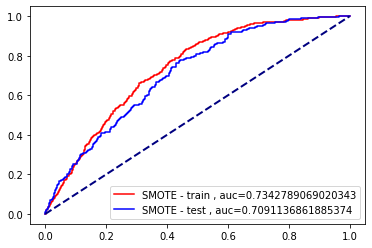

In [37]:
y_score_train = logreg_model.predict_proba(X_train)
fpr_train, tpr_train, _ = roc_curve(y_train,  y_score_train[:,1])
auc_train = roc_auc_score(y_train, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

### With SMOTE

In [18]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      4377
           1       0.66      0.70      0.68      4377

    accuracy                           0.67      8754
   macro avg       0.67      0.67      0.67      8754
weighted avg       0.67      0.67      0.67      8754

test set
              precision    recall  f1-score   support

           0       0.94      0.63      0.75      1860
           1       0.17      0.67      0.27       206

    accuracy                           0.63      2066
   macro avg       0.56      0.65      0.51      2066
weighted avg       0.87      0.63      0.70      2066



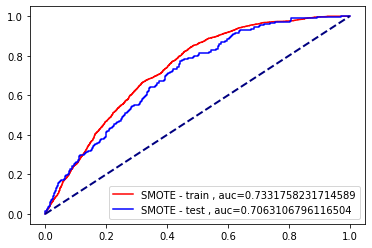

In [38]:
y_score_train = logreg_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## XGBoost

### XGBoost With SMOTE

In [19]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                              learning_rate =0.02,
                              n_estimators=100,
                              max_depth=2,
                              gamma=0.0,
                              colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.685758
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.697668
[2]	validation_0-auc:0.704075
[3]	validation_0-auc:0.702943
[4]	validation_0-auc:0.70265
[5]	validation_0-auc:0.702291
[6]	validation_0-auc:0.699581
[7]	validation_0-auc:0.715265
[8]	validation_0-auc:0.71609
[9]	validation_0-auc:0.717439
[10]	validation_0-auc:0.718054
[11]	validation_0-auc:0.71678
[12]	validation_0-auc:0.722292
[13]	validation_0-auc:0.722187
[14]	validation_0-auc:0.726309
[15]	validation_0-auc:0.726048
[16]	validation_0-auc:0.725341
[17]	validation_0-auc:0.72701
[18]	validation_0-auc:0.727594
[19]	validation_0-auc:0.727312
[20]	validation_0-auc:0.727072
[21]	validation_0-auc:0.72714
[22]	validation_0-auc:0.727085
[23]	validation_0-auc:0.725073
Stopping. Best iteration:
[18]	validation_0-auc:0.727594

training set
              precision    recall  f1-score   support

           0       0.76      0.63      0.69      4377
      

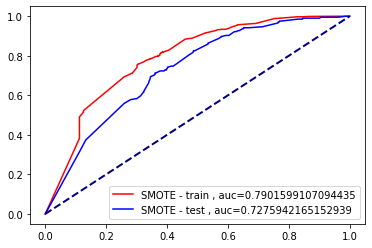

In [44]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

### Weighted XGBoost for Class Imbalance

reference : https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

In [43]:
print('XGBoost model - Weighted for Class Imbalance')

xgb_model = xgb.XGBClassifier(scale_pos_weight=20,eval_metric='auc')
                              # objective='binary:logistic', 
                              # learning_rate =0.02,
                              # n_estimators=100,
                              # max_depth=2,
                              # gamma=0.0,
                              # colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
predictions =  xgb_model.predict(X_train)
predicted_y.extend(predictions)
expected_y.extend(y_train)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - Weighted for Class Imbalance
[0]	validation_0-auc:0.705522
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.698622
[2]	validation_0-auc:0.706591
[3]	validation_0-auc:0.707976
[4]	validation_0-auc:0.706959
[5]	validation_0-auc:0.713458
[6]	validation_0-auc:0.712815
[7]	validation_0-auc:0.713139
[8]	validation_0-auc:0.718124
[9]	validation_0-auc:0.71637
[10]	validation_0-auc:0.71746
[11]	validation_0-auc:0.719712
[12]	validation_0-auc:0.722393
[13]	validation_0-auc:0.722951
[14]	validation_0-auc:0.723424
[15]	validation_0-auc:0.722933
[16]	validation_0-auc:0.723069
[17]	validation_0-auc:0.72403
[18]	validation_0-auc:0.726408
[19]	validation_0-auc:0.726088
[20]	validation_0-auc:0.725517
[21]	validation_0-auc:0.724877
[22]	validation_0-auc:0.72254
[23]	validation_0-auc:0.72311
Stopping. Best iteration:
[18]	validation_0-auc:0.726408

training set
              precision    recall  f1-score   support

           0       0.99      0.43    

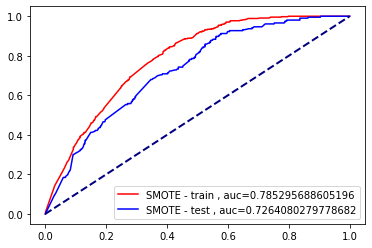

In [45]:
y_score_train = xgb_model.predict_proba(X_train)
fpr_train, tpr_train, _ = roc_curve(y_train,  y_score_train[:,1])
auc_train = roc_auc_score(y_train, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model.predict_proba(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()